# Demo of multiclass accuracy methods

When evaluating multiclass classification models, we sometimes need to adapt the metrics used in binary classification to work in this setting. We can do that by using OvR (one vs rest) and OvO strategies (one vs one).

How to adapt ROC Curve and ROC AUC metrics for multiclass classification.

## Import libraries

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
n_categories = 7
n_instances = 500

## Make dummy prediction

In [3]:
# Probability for each category, for each instance
proba = np.empty((n_instances,n_categories), dtype=object)
for i in range(n_instances):
    temp_array = np.random.randint(low=0, high=100, size=n_categories)
    temp_array = temp_array/temp_array.sum()
    proba[i,:] = temp_array

In [4]:
# Observation from the probability
# Use random integers ofor orginal
predicted = np.argmax(proba, axis=1)#observed = np.random.randint(low=0, high=n_categories, size=n_instances)

In [5]:
# Add random Gaussian noise, convert to integers, and clip to 0-6
noise = np.random.normal(loc=0, scale=1, size=n_instances)
observed = predicted  + noise
observed = observed.astype(int).clip(0,n_categories-1)

In [6]:
# Calculate error
error = observed - predicted

In [7]:
observed[1:10]

array([4, 5, 3, 5, 3, 4, 4, 6, 1])

In [8]:
predicted[1:10]

array([4, 4, 2, 5, 4, 5, 4, 6, 1])

In [9]:
error[1:10]

array([ 0,  1,  1,  0, -1, -1,  0,  0,  0])

## Show accuracy (identity)

In [10]:
accuracy = np.mean(error==0)
print (f'Accuracy: {accuracy:0.2f}')

error_within_one = np.mean(np.abs(error)<=1)
print (f'Error within 1: {error_within_one:0.2f}')

Accuracy: 0.45
Error within 1: 0.88


## Multiclass ROC AUC

https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a

https://github.com/vinyluis/Articles/blob/main/ROC%20Curve%20and%20ROC%20AUC/ROC%20Curve%20-%20Multiclass.ipynb


Functions are slightly modified from the binary classifier case

In [11]:

def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [12]:

def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [13]:

def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

### ROC Curve - One vs Rest (OvR)

Compares each class with the rest of the classes

In [14]:
classes = list(set(observed))#model_multiclass.classes_
classes

[0, 1, 2, 3, 4, 5, 6]

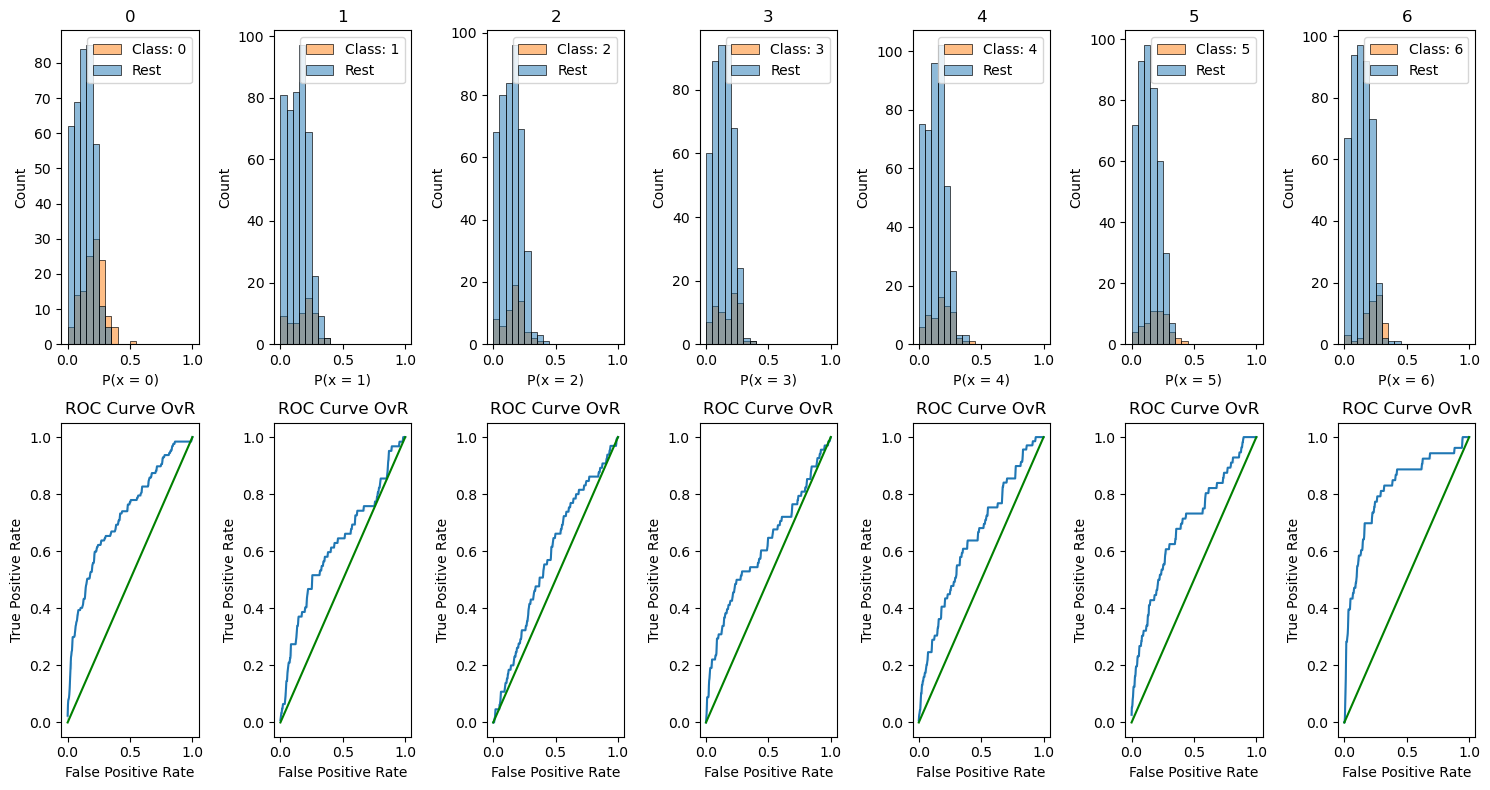

In [15]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (15, 8))
bins = [i/20 for i in range(20)] + [1]
classes = list(set(observed))#model.classes_
roc_auc_ovr = {}

for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame() #df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in observed]
    df_aux['prob'] = proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, len(classes), i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, len(classes), i+len(classes)+1)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

In [16]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")

0 ROC AUC OvR: 0.7260
1 ROC AUC OvR: 0.6224
2 ROC AUC OvR: 0.5822
3 ROC AUC OvR: 0.6192
4 ROC AUC OvR: 0.6510
5 ROC AUC OvR: 0.6902
6 ROC AUC OvR: 0.8153
average ROC AUC OvR: 0.6723


In [17]:

# Compares with sklearn (average only)
# "Macro" average = unweighted mean
roc_auc_score(observed, proba, labels = classes, multi_class = 'ovr', average = 'macro')

0.6723311845295104


### ROC Curve - One vs One (OvO)
Compares each possible combination of the classes, two at a time

In [18]:

classes_combinations = []
class_list = list(classes)
for i in range(len(class_list)):
    for j in range(i+1, len(class_list)):
        classes_combinations.append([class_list[i], class_list[j]])
        classes_combinations.append([class_list[j], class_list[i]])
classes_combinations

[[0, 1],
 [1, 0],
 [0, 2],
 [2, 0],
 [0, 3],
 [3, 0],
 [0, 4],
 [4, 0],
 [0, 5],
 [5, 0],
 [0, 6],
 [6, 0],
 [1, 2],
 [2, 1],
 [1, 3],
 [3, 1],
 [1, 4],
 [4, 1],
 [1, 5],
 [5, 1],
 [1, 6],
 [6, 1],
 [2, 3],
 [3, 2],
 [2, 4],
 [4, 2],
 [2, 5],
 [5, 2],
 [2, 6],
 [6, 2],
 [3, 4],
 [4, 3],
 [3, 5],
 [5, 3],
 [3, 6],
 [6, 3],
 [4, 5],
 [5, 4],
 [4, 6],
 [6, 4],
 [5, 6],
 [6, 5]]

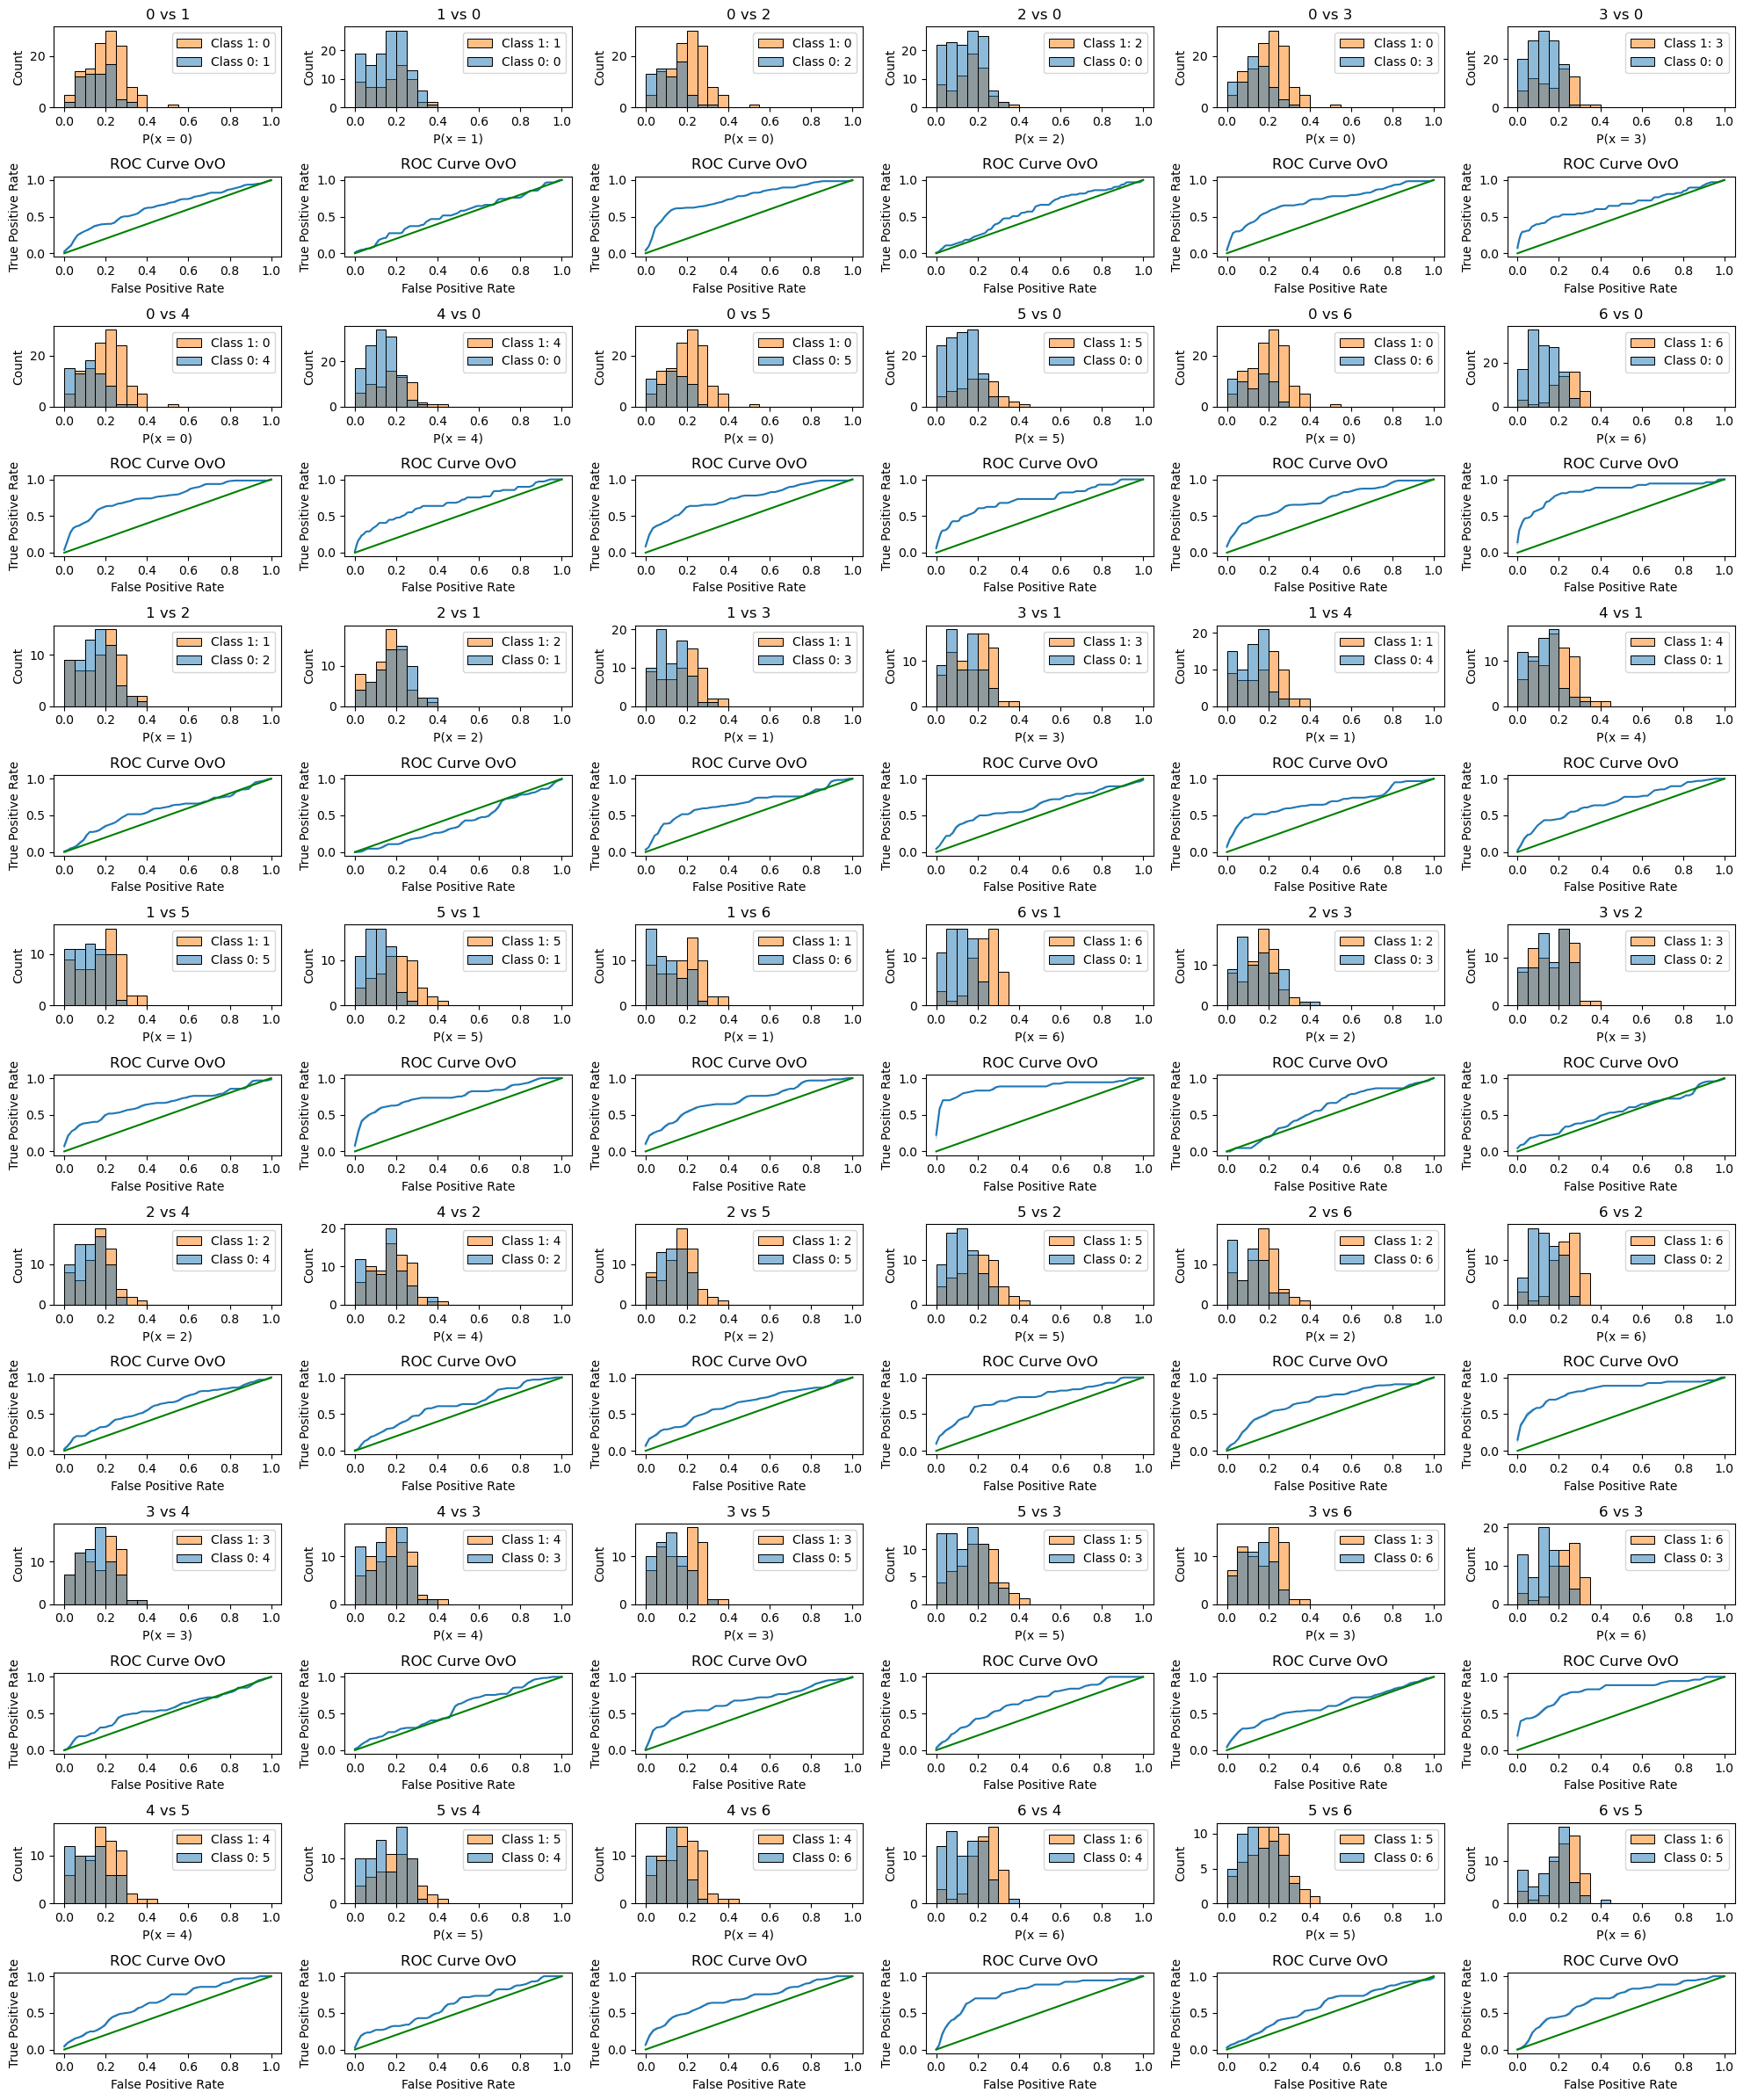

In [19]:
# Plots the Probability Distributions and the ROC Curves One vs ONe
fig_height = 4 * (n_categories-1)

plt.figure(figsize = (20, fig_height))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}

# For subplot placement
col_top = 0
group_count = 0

for i in range(len(classes_combinations)):
    # Gets the class
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
    title = str(c1) + " vs " + str(c2)
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame()#X_test.copy()
    df_aux['class'] = observed
    df_aux['prob'] = proba[:, c1_index]
    
    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)

    # Plots the probability distribution for the class and the rest
    group_count += 1
    col_top += 1
    if group_count == (n_categories):
        group_count = 1
        col_top = col_top + (n_categories-1)

    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2*n_categories, n_categories-1, col_top)#ax = plt.subplot(2, len(classes_combinations), i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(title)
    ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
    ax.set_xlabel(f"P(x = {c1})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    # Calculates the ROC Coordinates and plots the ROC Curves
    col_bottom = col_top + (n_categories-1)
    ax_bottom = plt.subplot(2*n_categories, n_categories-1, col_bottom)
#    ax_bottom = plt.subplot(2, len(classes_combinations), i+len(classes_combinations)+1)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvO")
    
    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()

In [20]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovo:
    avg_roc_auc += roc_auc_ovo[k]
    i += 1
    print(f"{k} ROC AUC OvO: {roc_auc_ovo[k]:.4f}")
print(f"average ROC AUC OvO: {avg_roc_auc/i:.4f}")

0 vs 1 ROC AUC OvO: 0.6389
1 vs 0 ROC AUC OvO: 0.5386
0 vs 2 ROC AUC OvO: 0.7612
2 vs 0 ROC AUC OvO: 0.5838
0 vs 3 ROC AUC OvO: 0.7219
3 vs 0 ROC AUC OvO: 0.6605
0 vs 4 ROC AUC OvO: 0.7597
4 vs 0 ROC AUC OvO: 0.6809
0 vs 5 ROC AUC OvO: 0.7459
5 vs 0 ROC AUC OvO: 0.7280
0 vs 6 ROC AUC OvO: 0.7250
6 vs 0 ROC AUC OvO: 0.8427
1 vs 2 ROC AUC OvO: 0.5749
2 vs 1 ROC AUC OvO: 0.4185
1 vs 3 ROC AUC OvO: 0.6656
3 vs 1 ROC AUC OvO: 0.6366
1 vs 4 ROC AUC OvO: 0.6861
4 vs 1 ROC AUC OvO: 0.6856
1 vs 5 ROC AUC OvO: 0.6570
5 vs 1 ROC AUC OvO: 0.7624
1 vs 6 ROC AUC OvO: 0.7066
6 vs 1 ROC AUC OvO: 0.8813
2 vs 3 ROC AUC OvO: 0.5676
3 vs 2 ROC AUC OvO: 0.5432
2 vs 4 ROC AUC OvO: 0.6132
4 vs 2 ROC AUC OvO: 0.6163
2 vs 5 ROC AUC OvO: 0.6387
5 vs 2 ROC AUC OvO: 0.7271
2 vs 6 ROC AUC OvO: 0.6888
6 vs 2 ROC AUC OvO: 0.8311
3 vs 4 ROC AUC OvO: 0.5654
4 vs 3 ROC AUC OvO: 0.5635
3 vs 5 ROC AUC OvO: 0.6696
5 vs 3 ROC AUC OvO: 0.6732
3 vs 6 ROC AUC OvO: 0.6096
6 vs 3 ROC AUC OvO: 0.8171
4 vs 5 ROC AUC OvO: 0.6492
5

In [21]:
roc_auc_0v0 = np.empty((n_categories,n_categories), dtype=object)

# Displays the ROC AUC for each class
for k in roc_auc_ovo:
    roc_auc_0v0[int(k[0]),int(k[-1])] = roc_auc_ovo[k]

# No entry for diagonal, fill with zero
np.fill_diagonal(roc_auc_0v0, 0)

# Convert to flaot
roc_auc_0v0 = roc_auc_0v0.astype(float)

Show the ROC AUC for the OvO as a heat map.

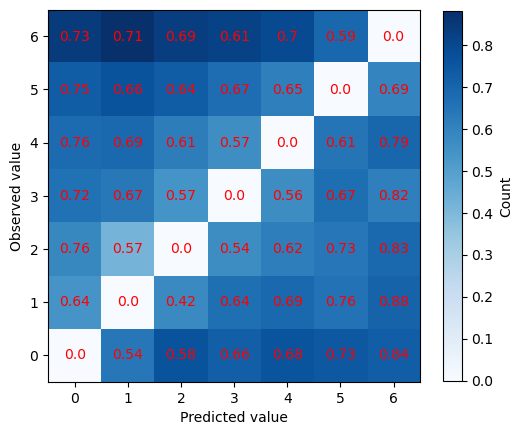

In [22]:
# Visualize the confusion matrix with colors
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1,1,1)
heatmap = plt.imshow(roc_auc_0v0, cmap=plt.cm.Blues, origin='lower')
colorbar = plt.colorbar(heatmap, shrink=0.8, ax=ax1, alpha=0.5, label='Count')

# To add values to plot
for i in range(len(roc_auc_0v0)):
    for j in range(len(roc_auc_0v0[0])):
        plt.text(i, j, roc_auc_0v0[i][j].round(2), ha='center', va='center', color='r')

ax1.set_xlabel('Predicted value')
ax1.set_ylabel('Observed value')
plt.show()

In [23]:
# Compares with sklearn (average only)
# "Macro" average = unweighted mean
roc_auc_score(observed, proba, labels = classes, multi_class = 'ovo', average = 'macro')

0.671851823302625